# Import

In [ ]:
!pip install opendatasets
!pip install pandas
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 7.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import glob
import tensorflow as tf
import tensorflow_addons as tfa
import math
from tqdm import tqdm
import imageio
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import opendatasets as od
import os
import shutil
from PIL import Image
import zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Kaggle/kaggle.json /content/

In [ ]:
od.download('https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge')

100%|██████████| 5.11G/5.11G [03:59<00:00, 22.9MB/s]


In [ ]:
!rm -rf /content/lyft-udacity-challenge/dataa /content/lyft-udacity-challenge/datab /content/lyft-udacity-challenge/datac /content/lyft-udacity-challenge/datad /content/lyft-udacity-challenge/datae

# Data import

In [ ]:
image_path = ["/content/lyft-udacity-challenge/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B', 'C', 'D', 'E']]
mask_path = ["/content/lyft-udacity-challenge/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B', 'C', 'D', 'E']]

In [ ]:
def list_image_paths(directory_paths):
    image_paths = []
    for directory in range(len(directory_paths)):
        image_filenames = os.listdir(directory_paths[directory])
        for image_filename in image_filenames:
            image_paths.append(directory_paths[directory] + image_filename)
    return image_paths

In [ ]:
image_paths = list_image_paths(image_path)
mask_paths = list_image_paths(mask_path)
number_of_images, number_of_masks = len(image_paths), len(mask_paths)
print(f"1. There are {number_of_images} images and {number_of_masks} masks in our dataset")
print(f"2. An example of an image path is: \n {image_paths[0]}")
print(f"3. An example of a mask path is: \n {mask_paths[0]}")

1. There are 5000 images and 5000 masks in our dataset
2. An example of an image path is: 
 /content/lyft-udacity-challenge/dataA/dataA/CameraRGB/06_00_021.png
3. An example of a mask path is: 
 /content/lyft-udacity-challenge/dataA/dataA/CameraSeg/06_00_021.png


<ipython-input-61-42530e7671d8>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_paths[N])
<ipython-input-61-42530e7671d8>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_paths[N])


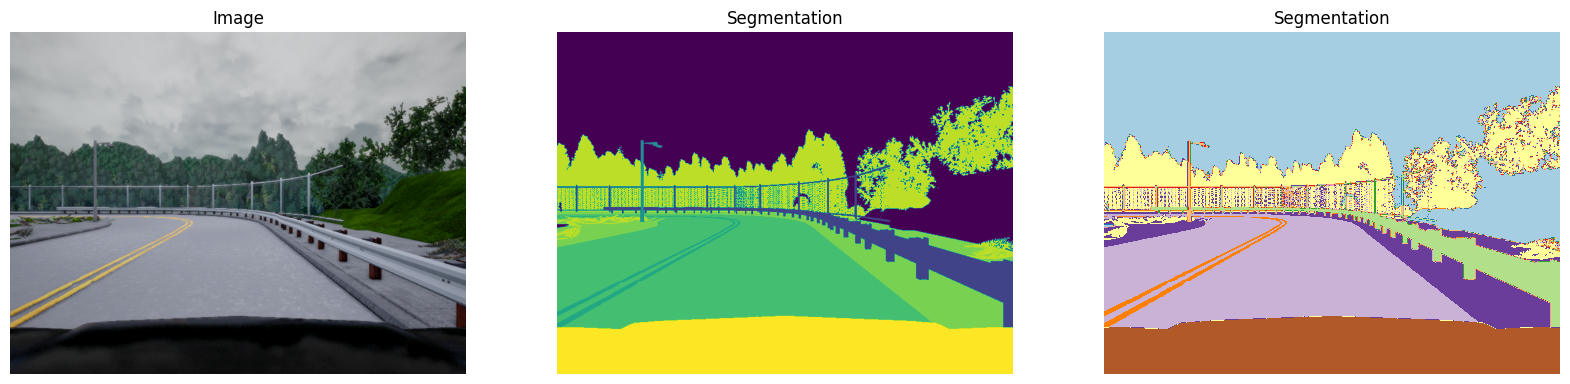

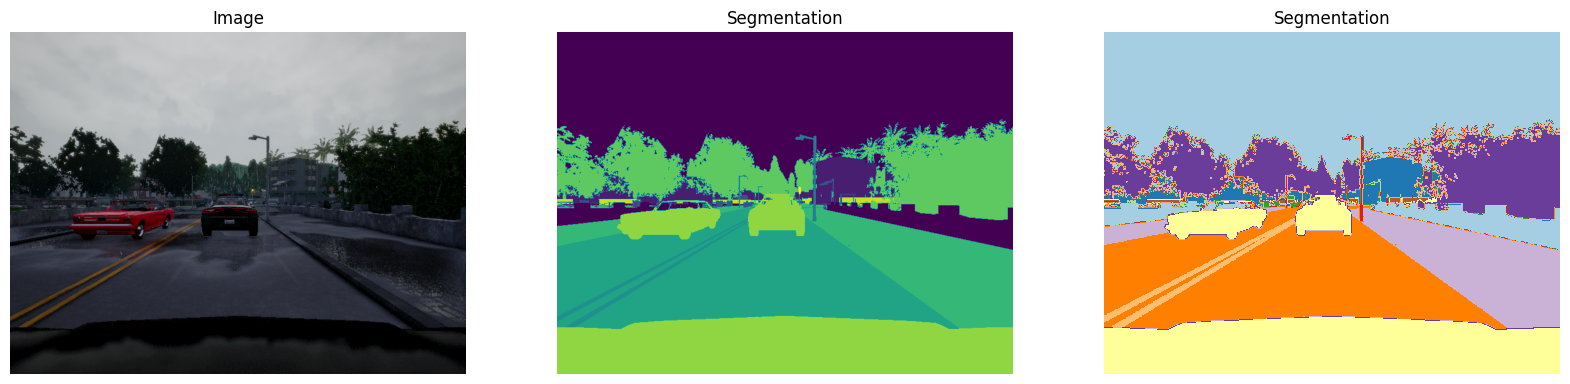

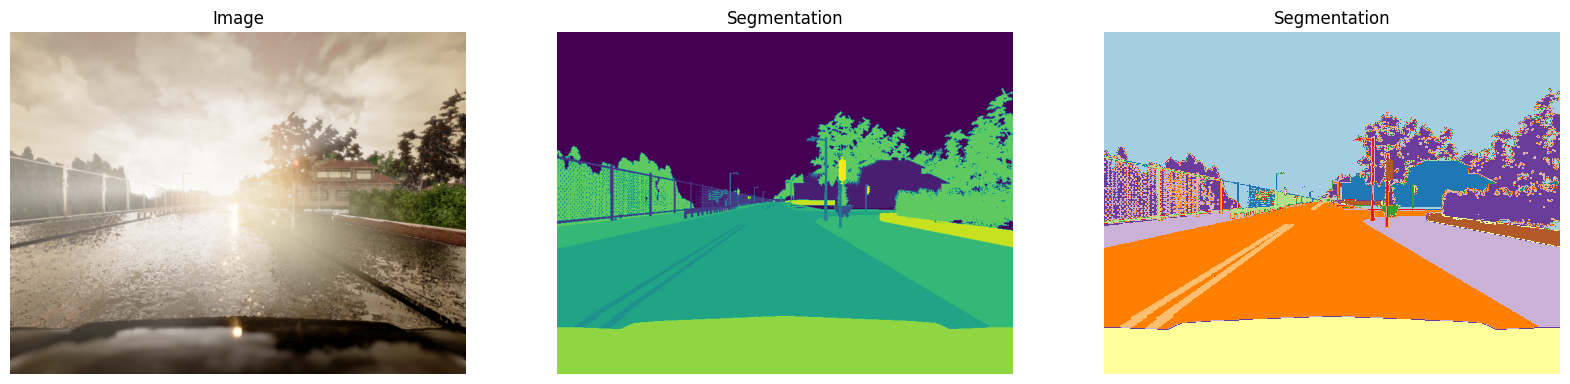

In [ ]:
import random
number_of_samples = len(image_paths)

for i in range(3):
    N = random.randint(0, number_of_samples - 1)

    img = imageio.imread(image_paths[N])
    mask = imageio.imread(mask_paths[N])
    mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(mask)
    arr[1].set_title('Segmentation')
    arr[1].axis("off")
    arr[2].imshow(mask, cmap='Paired')
    arr[2].set_title('Segmentation')
    arr[2].axis("off")

In [ ]:
# First split the image paths into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, train_size=0.8, random_state=0)

# Keep part of the validation set as test set
validation_image_paths, test_image_paths, validation_mask_paths, test_mask_paths = train_test_split(val_image_paths, val_mask_paths, train_size = 0.80, random_state=0)

print(f'There are {len(train_image_paths)} images in the Training Set')
print(f'There are {len(validation_image_paths)} images in the Validation Set')
print(f'There are {len(test_image_paths)} images in the Test Set')

There are 4000 images in the Training Set
There are 800 images in the Validation Set
There are 200 images in the Test Set


In [ ]:
import tensorflow_addons as tfa
import math

In [ ]:
def read_image(image_path, mask_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (256, 256), method='nearest')

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (256, 256), method='nearest')

    random_rotate = random.randint(0, 30)
    image = tfa.image.rotate(image, random_rotate * math.pi / 180)
    mask = tfa.image.rotate(mask, random_rotate * math.pi / 180)

    random_flip = random.randint(0, 1)
    if random_flip == 1:
       image = tf.image.flip_left_right(image)
       mask = tf.image.flip_left_right( mask)
    return image, mask

In [ ]:
def data_generator(image_paths, mask_paths, buffer_size, batch_size):

    image_list = tf.constant(image_paths)
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)

    return dataset

In [ ]:
batch_size = 32
buffer_size = 500

train_dataset = data_generator(train_image_paths, train_mask_paths, buffer_size, batch_size)
validation_dataset = data_generator(validation_image_paths, validation_mask_paths, buffer_size, batch_size)
test_dataset = data_generator(test_image_paths, test_mask_paths, buffer_size, batch_size)

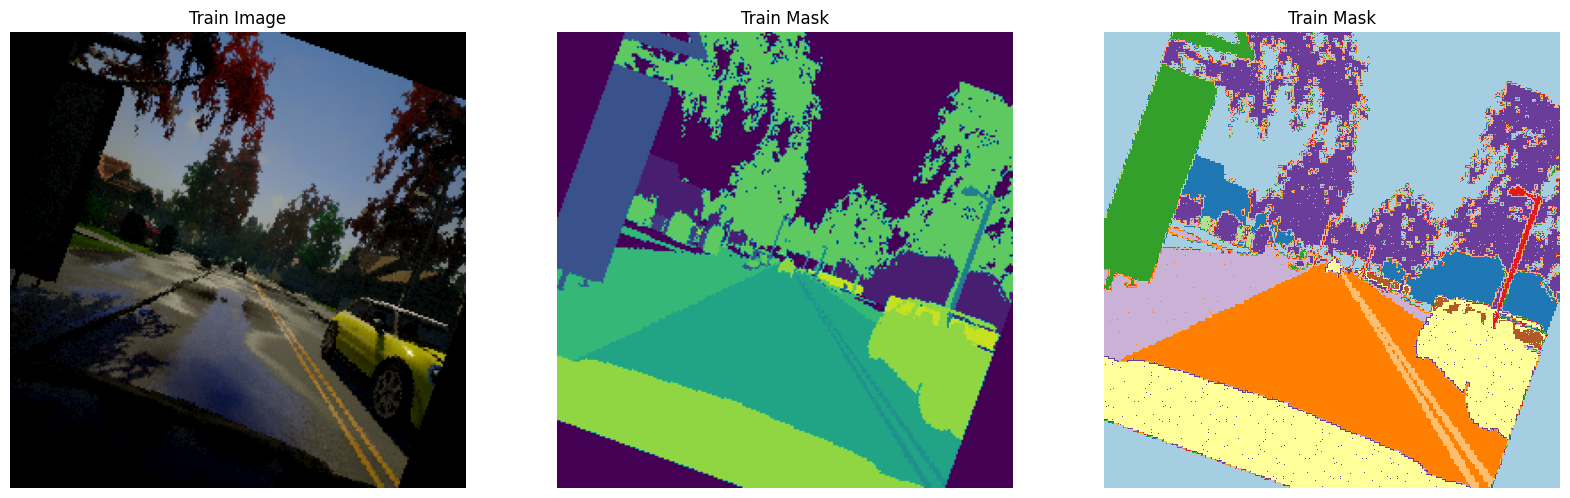

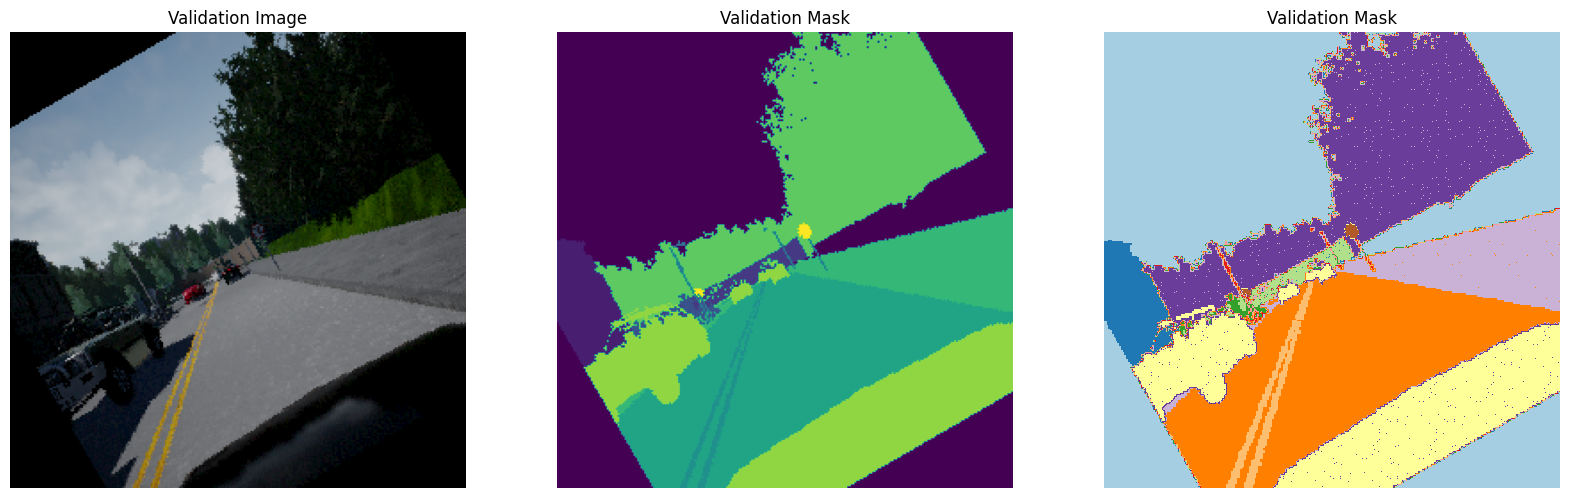

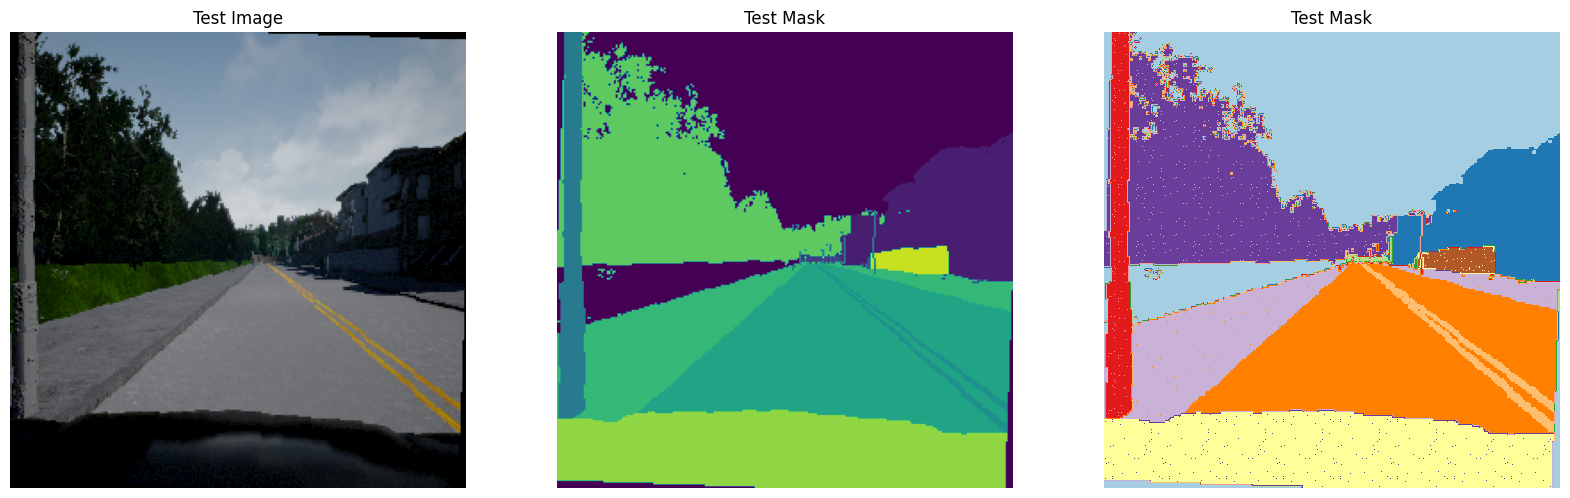

In [ ]:
# Take a batch (32 images and their labelled segmentations from each category of data)
for train_images, train_masks in train_dataset:
    break
for validation_images, validation_masks in validation_dataset:
    break
for test_images, test_masks in test_dataset:
    break


for i in range(3):
    N = random.randint(0, batch_size-1)

    images = [train_images[N], validation_images[N], test_images[N]]
    masks = [train_masks[N], validation_masks[N], test_masks[N]]
    title = ['Train Image', 'Validation Image', 'Test Image', 'Train Mask', 'Validation Mask', 'Test Mask']

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(images[i])
    arr[0].set_title(title[i])
    arr[0].axis("off")
    arr[1].imshow(masks[i])
    arr[1].set_title(title[i+3])
    arr[1].axis("off")
    arr[2].imshow(masks[i], cmap='Paired')
    arr[2].set_title(title[i+3])
    arr[2].axis("off")

#Model

In [ ]:
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding='same')(inputs) #convolution (Downsampling) layer
    x = BatchNormalization()(x) #Batch normalization
    x = Activation('relu')(x) #ReLU (Rectified Linear Unit) Activation Function

    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if pool == True:
        p = MaxPool2D((2,2))(x) #Maxpooling layer
        return x, p # x is filters and p is output feature map obtained after maxpooling
    else:
        return x


def build_unet(shape, num_classes):   # this function is used to create unet architecture using conv_block function
    inputs = Input(shape)

    filters_x = [16,32,48,64,64,48,32,16]
    filters_b = [128]

    # Encoder : Encoder path consist of 4 blocks
    # Encoder path is used to capture context (feature map) of input image in order to do segmentation
    x1, p1 = conv_block(inputs, filters_x[0], pool=True)
    x2, p2 = conv_block(p1, filters_x[1], pool=True)
    x3, p3 = conv_block(p2, filters_x[2], pool=True)
    x4, p4 = conv_block(p3, filters_x[3], pool=True)

    # Bridge
    b1 = conv_block(p4, filters_b[0], pool=False) #Bridge is used to pass context from Encoder layer to Decoder layer

    # Decoder : Decoder path consist of 4 blocks
    # Decoder path is used to reconstruct segmentation image from contracted image obtained from encoder path
    u1 = UpSampling2D((2,2), interpolation='bilinear')(b1) #DeConvolution (upsampling) layer for upsizing image.
    c1 = Concatenate()([u1, x4]) #Concatenation layer - It concatenates current image with corresponding image from encoder path to increase pixel precision.
    x5 = conv_block(c1, filters_x[4], pool=False) #convolution layer with no pooling

    u2 = UpSampling2D((2,2), interpolation='bilinear')(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, filters_x[5], pool=False)

    u3 = UpSampling2D((2,2), interpolation='bilinear')(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, filters_x[6], pool=False)

    u4 = UpSampling2D((2,2), interpolation='bilinear')(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, filters_x[7], pool=False)

    # Output Layer
    output = Conv2D(num_classes, 1, padding='same', activation='softmax')(x8) # Output layer to create segmentation image of same size.
    # 'softmax' activation function is used to classify pixels into different classes

    return Model(inputs, output)

In [156]:
## Define the resolution of the images and the number of classes

H = IMG_SIZE
W = IMG_SIZE
num_classes = 13
#calling function to build model
unet = build_unet((H, W, 3), num_classes)

In [157]:
unet.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_152 (Conv2D)         (None, 256, 256, 16)         448       ['input_9[0][0]']             
                                                                                                  
 batch_normalization_144 (B  (None, 256, 256, 16)         64        ['conv2d_152[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_144 (Activation  (None, 256, 256, 16)         0         ['batch_normalization_14

In [158]:
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train

In [205]:
from tensorflow.keras.models import Model, load_model
unet = load_model('/content/unet-image-segmentation-model2.h5')

In [180]:
eps = 50
bs = 32

In [194]:
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, min_lr=1e-6)
early_stop = EarlyStopping( patience=5, restore_best_weights=True)

In [195]:
history = unet.fit(train_dataset,
epochs=eps,
batch_size=bs,
shuffle=True,
validation_data=validation_dataset,
callbacks=[#reduce_lr,
           early_stop],verbose=1)

Epoch 1/50
125/125 [==============================] - 53s 363ms/step - loss: 0.3890 - accuracy: 0.9047 - val_loss: 3.1440 - val_accuracy: 0.2583
Epoch 2/50
125/125 [==============================] - 44s 354ms/step - loss: 0.2347 - accuracy: 0.9390 - val_loss: 2.1713 - val_accuracy: 0.4366
Epoch 3/50
125/125 [==============================] - 44s 356ms/step - loss: 0.1884 - accuracy: 0.9486 - val_loss: 1.6326 - val_accuracy: 0.6015
Epoch 4/50
125/125 [==============================] - 44s 356ms/step - loss: 0.1627 - accuracy: 0.9547 - val_loss: 1.8180 - val_accuracy: 0.5856
Epoch 5/50
125/125 [==============================] - 44s 355ms/step - loss: 0.1447 - accuracy: 0.9585 - val_loss: 1.9065 - val_accuracy: 0.5883
Epoch 6/50
125/125 [==============================] - 45s 358ms/step - loss: 0.1313 - accuracy: 0.9614 - val_loss: 1.8927 - val_accuracy: 0.6146
Epoch 7/50
125/125 [==============================] - 44s 354ms/step - loss: 0.1205 - accuracy: 0.9638 - val_loss: 1.9099 - val_ac

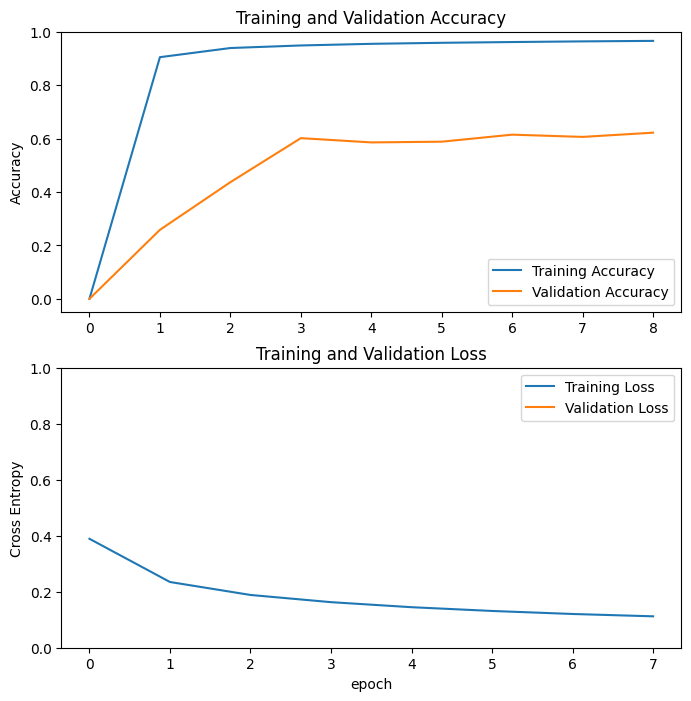

In [196]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [197]:
unet.save('unet-image-segmentation-model3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [206]:
train_loss, train_accuracy = unet.evaluate(train_dataset, batch_size = 32)
validation_loss, validation_accuracy = unet.evaluate(validation_dataset, batch_size = 32)
test_loss, test_accuracy = unet.evaluate(test_dataset, batch_size = 32)

7/7 [==============================] - 1s 95ms/step - loss: 0.5059 - accuracy: 0.8764


In [207]:
print(f'Model Accuracy on the Training Dataset: {round(train_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Validation Dataset: {round(validation_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Test Dataset: {round(test_accuracy * 100, 2)}%')

Model Accuracy on the Training Dataset: 96.39%
Model Accuracy on the Validation Dataset: 62.72%
Model Accuracy on the Test Dataset: 87.64%


In [200]:
def iou_score(dataset):

    """
    Argument:
        dataset -- the dataset to calculate IoU on

    Returns:
        min_iou -- minimum IoU
        max_iou -- maximum IoU
        mean_iou -- mean IoU ()
        """
    # Create empty lists
    intersections, unions, max_ious, min_ious = [], [], [], []

    for images, masks in dataset:
        pred_mask = unet.predict(images)
        intersection = np.logical_and(masks, pred_mask)
        union = np.logical_or(masks, pred_mask)
        intersection_sum = np.array([np.sum(inter) for inter in intersection])
        union_sum = np.array([np.sum(un) for un in union])
        batch_iou_score = intersection_sum / union_sum
        batch_min_iou = np.amin(batch_iou_score)
        batch_max_iou = np.amax(batch_iou_score)

        intersections.append(np.sum(intersection))
        unions.append(np.sum(union))
        min_ious.append(batch_min_iou)
        max_ious.append(batch_max_iou)

    min_iou = np.amin(min_ious)
    max_iou = np.amax(max_ious)
    mean_iou = np.sum(intersections) / np.sum(unions)

    return min_iou, max_iou, mean_iou

In [208]:
train_min_iou, train_max_iou, train_mean_iou = iou_score(train_dataset)
validation_min_iou, validation_max_iou, validation_mean_iou = iou_score(validation_dataset)
test_min_iou, test_max_iou, test_mean_iou = iou_score(test_dataset)

1/1 [==============================] - 0s 343ms/step


In [209]:
print(f'IoU on the Training Dataset: \n Minimum IoU Score: {round(train_min_iou*100, 2)}% \n Maximum IoU Score: {round(train_max_iou*100, 2)}% \n Mean IoU Score: {round(train_mean_iou*100, 2)}% \n')
print(f'IoU on the Validation Dataset: \n Minimum IoU Score: {round(validation_min_iou*100, 2)}% \n Maximum IoU Score: {round(validation_max_iou*100, 2)}% \n Mean Iou Score: {round(validation_mean_iou*100, 2)}% \n')
print(f'IoU on the Test Dataset: \n Minimum IoU Score: {round(test_min_iou*100, 2)}% \n Maximum IoU Score: {round(test_max_iou*100, 2)}% \n Mean IoU Score: {round(test_mean_iou*100, 2)}% \n')

IoU on the Training Dataset: 
 Minimum IoU Score: 45.78% 
 Maximum IoU Score: 73.72% 
 Mean IoU Score: 60.81% 

IoU on the Validation Dataset: 
 Minimum IoU Score: 45.06% 
 Maximum IoU Score: 71.4% 
 Mean Iou Score: 58.9% 

IoU on the Test Dataset: 
 Minimum IoU Score: 51.64% 
 Maximum IoU Score: 83.1% 
 Mean IoU Score: 68.55% 



In [ ]:
# Load model
from tensorflow.keras.models import Model, load_model
model = load_model('unet-image-segmentation-model.h5')

In [177]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [145]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [210]:
def show_predictions(dataset, num):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 32ms/step


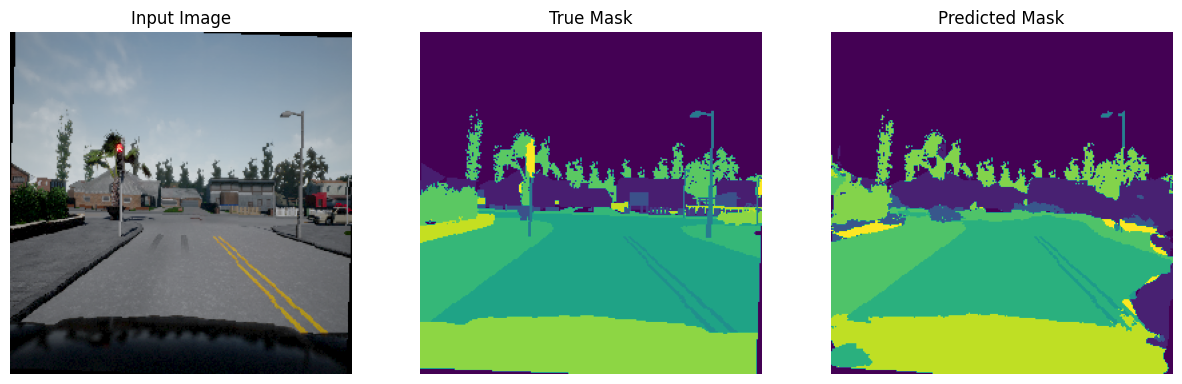

1/1 [==============================] - 0s 31ms/step


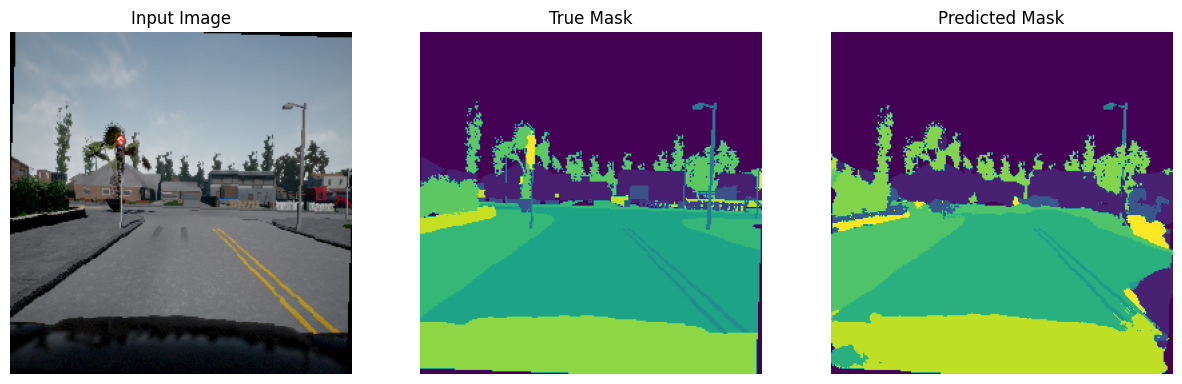

1/1 [==============================] - 0s 37ms/step


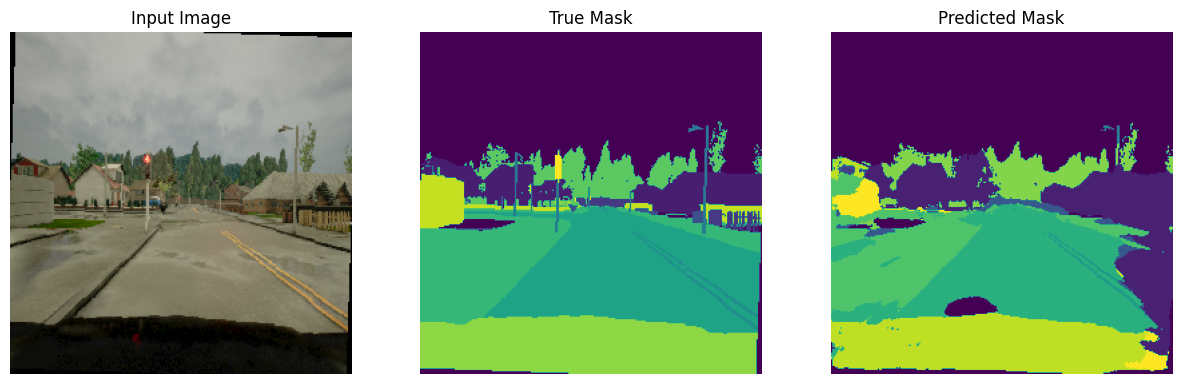

1/1 [==============================] - 0s 36ms/step


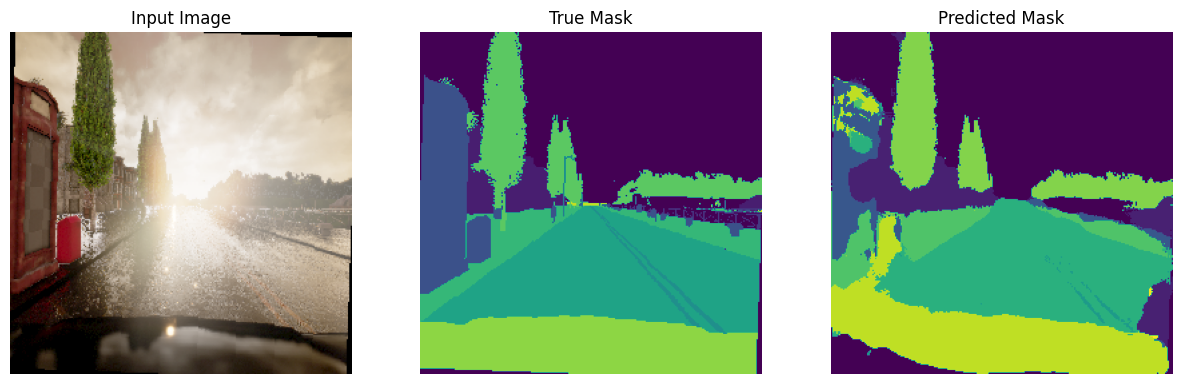

1/1 [==============================] - 0s 37ms/step


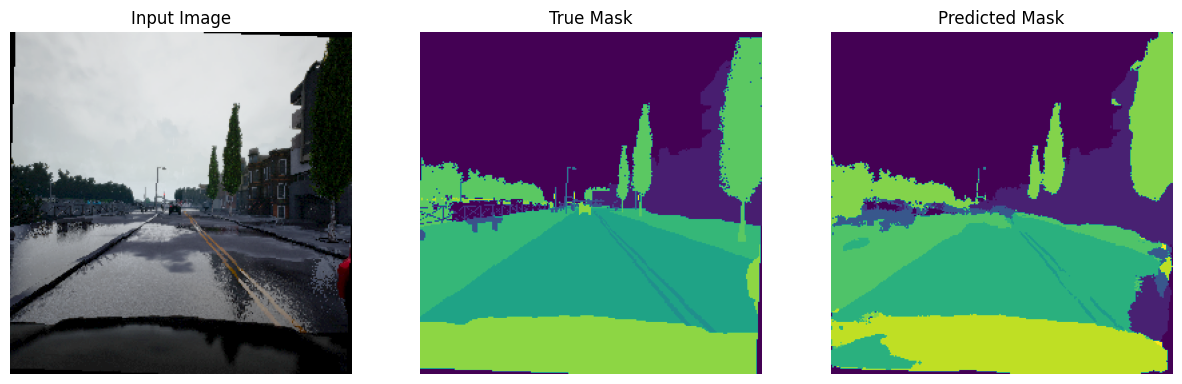

1/1 [==============================] - 0s 36ms/step


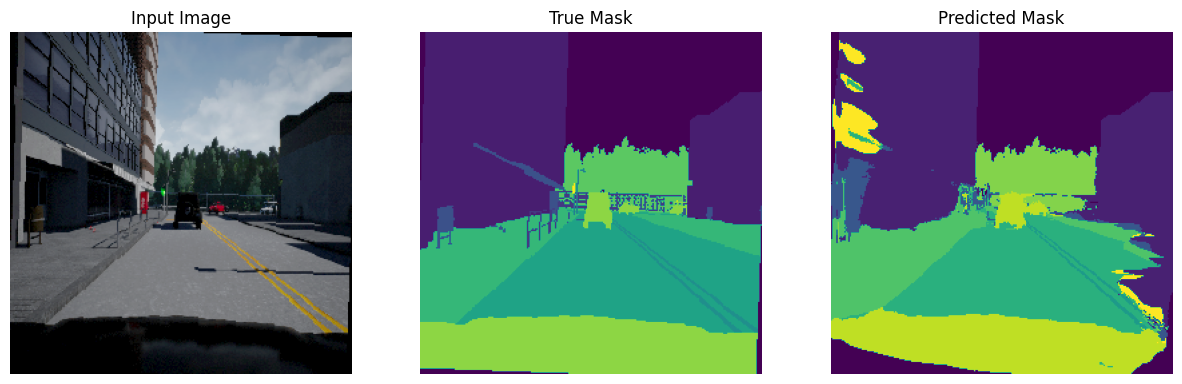

In [211]:
show_predictions(test_dataset, 6)